LSH Method

In [9]:
import numpy as np

# Example datasets for 1D, 2D, and 3D
X_1D = np.array([[1], [2], [3], [4], [5]])
X_2D = np.array([[1, 9], [2, 3], [4, 1], [3, 7], [5, 4]])
X_3D = np.array([[1, 9, 3], [2, 3, 7], [4, 1, 5], [3, 7, 2], [5, 4, 8]])

query_pts_1D = np.array([[0], [7]])
query_pts_2D = np.array([[7, 4], [1, 7]])
query_pts_3D = np.array([[2, 9, 1], [4, 3, 7]])

def random_projections(X, query_pts, P):
    np.random.seed(35)
    R = np.random.randn(X.shape[1] + 1, P)  # +1 for the bias term
    X_proj = np.dot(np.hstack([X, np.ones((X.shape[0], 1))]), R)
    query_pts_proj = np.dot(np.hstack([query_pts, np.ones((query_pts.shape[0], 1))]), R)
    return X_proj, query_pts_proj, R

def pairwise_dist_naive(x: np.ndarray, y: np.ndarray) -> float:
    return np.sqrt(np.sum((x - y) ** 2))

def lsh_train(X, query_pts, P):
    return random_projections(X, query_pts, P)

def lsh_test(X, X_proj, query_pts_proj):
    
    neighbors = []
    for query_pt_proj in query_pts_proj:
        query_region = np.sign(query_pt_proj)
        n = X_proj.shape[0]
        distances = np.full(n, np.inf)  # Initialize distances with infinities
        for i in range(n):
            if np.array_equal(np.sign(X_proj[i]), query_region):
                distances[i] = pairwise_dist_naive(X_proj[i], query_pt_proj)
        
        nearest_neighbor_index = np.argmin(distances)
        neighbors.append((X[nearest_neighbor_index], distances[nearest_neighbor_index]))
    
    return neighbors

# Test the function for 1D, 2D, and 3D
P = 3  # Number of projections

for X, query_pts in [(X_1D, query_pts_1D), (X_2D, query_pts_2D), (X_3D, query_pts_3D)]:
    X_proj, query_pts_proj, R = lsh_train(X, query_pts, P)
    neighbors = lsh_test(X,X_proj, query_pts_proj)
    print("\nDimension:", X.shape[1])
    print("Query Point\tNearest Neighbor\tDistance")
    for query_pt, (neighbor, dist) in zip(query_pts, neighbors):
        print(f"{query_pt}\t{neighbor}\t{dist:.6f}")





Dimension: 1
Query Point	Nearest Neighbor	Distance
[0]	[1]	2.080615
[7]	[5]	4.161230

Dimension: 2
Query Point	Nearest Neighbor	Distance
[7 4]	[5 4]	4.161230
[1 7]	[1 9]	3.754138

Dimension: 3
Query Point	Nearest Neighbor	Distance
[2 9 1]	[3 7 2]	4.927726
[4 3 7]	[4 1 5]	0.675591


KD Tree

In [10]:
from sklearn.neighbors import KDTree
import numpy as np


def kd_train(X):
    return KDTree(X, leaf_size=30)

def kd_test(X, query_pts, n_neighbors,kdtree):
    """
    X: numpy array of shape (n, d)
    query_pts: numpy array of shape (m, d), where m is the number of query points
    n_neighbors: int, number of neighbors to consider for each query point
    
    Returns the formatted output of the query point, nearest point(s), and distance(s)
    """
    kdtree = KDTree(X, leaf_size=30)  # Adjust the leaf_size based on your dataset
    distances, indices = kdtree.query(query_pts, k=n_neighbors)
    
    results = []
    for i, (dist, idx) in enumerate(zip(distances, indices)):
        for j in range(n_neighbors):
            results.append({
                'Query Point': query_pts[i],
                'Nearest Point': X[idx[j]],
                'Distance': dist[j]
            })
    return results

# Example usage
X = np.array([[1, 9,1], [2, 3,4], [4, 1,2]])
query_pts = np.array([[7, 4,1], [1, 8,3]])  # Multiple query points
k = 1  # Number of neighbors to find
kdtree = kd_train(X)
results = kd_test(X, query_pts, k,kdtree)
for result in results:
    print("Query Point: {}, Nearest Point: {}, Distance: {:.2f}".format(
        result['Query Point'], result['Nearest Point'], result['Distance']
    ))


Query Point: [7 4 1], Nearest Point: [4 1 2], Distance: 4.36
Query Point: [1 8 3], Nearest Point: [1 9 1], Distance: 2.24


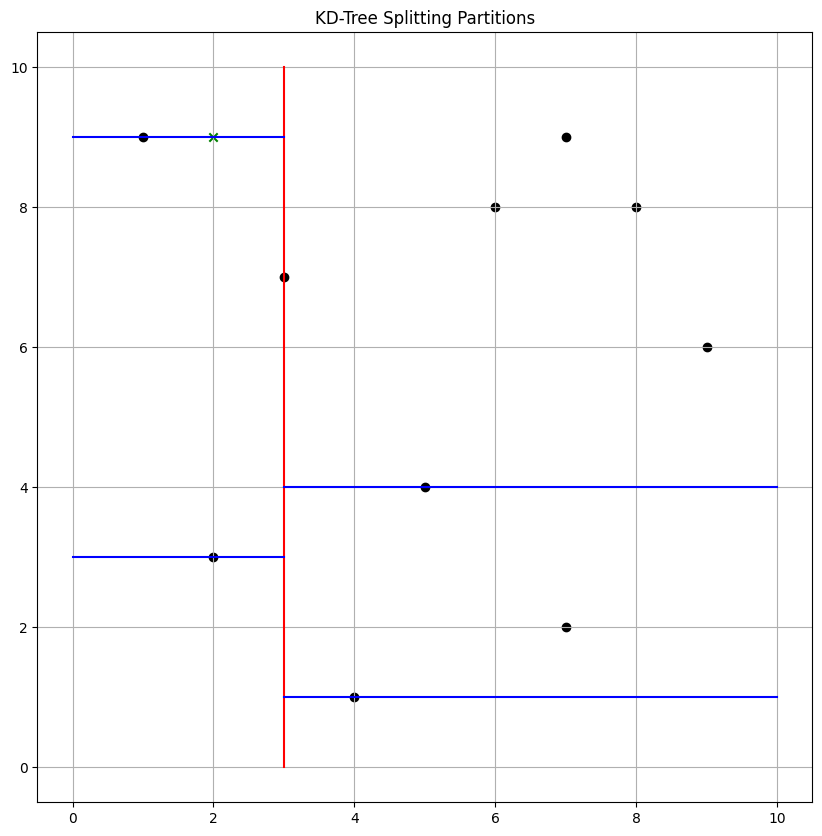

In [19]:
import numpy as np

# X = np.array([[1, 9], [2, 3], [4, 1], [3, 7], [5, 4], [6, 8], [7, 2], [8, 8], [7, 9], [9, 6]])
# query_pt = np.array([7, 4])

query_pt =query_pts_3D[0]

class KDNode:
    def __init__(self, point, left=None, right=None):
        self.point = point
        self.left = left
        self.right = right

def build_kdtree(points, depth=0):
    n = len(points)
    if n == 0:
        return None

    k = len(points[0])  # assumes all points have the same dimension
    axis = depth % k

    # Sort point array and choose median as pivot element
    sorted_points = sorted(points, key=lambda point: point[axis])
    median_index = n // 2

    # Create node and recursively construct subtrees
    return KDNode(
        point=sorted_points[median_index],
        left=build_kdtree(sorted_points[:median_index], depth + 1),
        right=build_kdtree(sorted_points[median_index + 1:], depth + 1)
    )

# Build KD-Tree
kd_tree = build_kdtree(X_3D)

import matplotlib.pyplot as plt

def plot_kdtree(node, min_x, max_x, min_y, max_y, depth=0):
    if node is not None:
        # Determine axis and draw the line
        k = len(node.point)
        axis = depth % k

        if axis == 0:
            plt.plot([node.point[0], node.point[0]], [min_y, max_y], 'r-')
            plot_kdtree(node.left, min_x, node.point[0], min_y, max_y, depth + 1)
            plot_kdtree(node.right, node.point[0], max_x, min_y, max_y, depth + 1)
        else:
            plt.plot([min_x, max_x], [node.point[1], node.point[1]], 'b-')
            plot_kdtree(node.left, min_x, max_x, min_y, node.point[1], depth + 1)
            plot_kdtree(node.right, min_x, max_x, node.point[1], max_y, depth + 1)

# Plot points and query point
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c='k')
plt.scatter(query_pt[0], query_pt[1], c='g', marker='x')  # query point in green

# Call the function with initial bounds
plot_kdtree(kd_tree, min(X[:, 0])-1, max(X[:, 0])+1, min(X[:, 1])-1, max(X[:, 1])+1)

plt.grid(True)
plt.title('KD-Tree Splitting Partitions')
plt.show()


Naive Method

In [23]:
import numpy as np

X = np.array([[1, 9], [2, 3], [4, 1], [3, 7], [5, 4], [6, 8], [7, 2], [8, 8], [7, 9], [9, 6]])
query_pt = np.array([2, 5])

def pairwise_dist_naive(x: np.ndarray, y: np.ndarray) -> float:
    return np.sqrt(np.sum((x - y) ** 2))

def naive_knn(data, query, k):
    n = len(data)
    distances = np.zeros(n)
    
    # Calculate the Euclidean distance from the query point to all other points in the dataset using a for-loop
    for i in range(n):
        distances[i] = pairwise_dist_naive(data[i], query)
    
    # Get the indices of the sorted distances
    sorted_indices = np.argsort(distances)
    
    # Select the top k nearest neighbors
    nearest_neighbors = data[sorted_indices][:k]
    
    return nearest_neighbors

# Example usage
k = 1
nearest_neighbors = naive_knn(X, query_pt, k)
print("Nearest Neighbors:")
print(nearest_neighbors)


Nearest Neighbors:
[[2 3]]


In [41]:
import numpy as np
import time
import psutil
import pandas as pd

# Function to generate datasets with varying sizes and dimensions
def generate_dataset(size, dimensions):
    return np.random.rand(size, dimensions)

# Measure memory usage
def memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / (1024 * 1024)  # Convert to MB

# Function to train and test LSH variant
def train_test_lsh(X, query_pts, P):
    start_time = time.time()
    X_proj, query_pts_proj, R = lsh_train(X, query_pts, P)
    train_time = (time.time() - start_time) * 1e6  # Convert to microseconds
    start_time = time.time()
    neighbors = lsh_test(X, X_proj, query_pts_proj)
    test_time = (time.time() - start_time) * 1e6  # Convert to microseconds
    memory_usage_diff = memory_usage()
    return train_time, test_time, memory_usage_diff

# Function to train and test KD-Tree variant
def train_test_kd(X, query_pts, k):
    start_time = time.time()
    kdtree = kd_train(X)
    train_time = (time.time() - start_time) * 1e6  # Convert to microseconds
    start_time = time.time()
    results = kd_test(X, query_pts, k, kdtree)
    test_time = (time.time() - start_time) * 1e6  # Convert to microseconds
    memory_usage_diff = memory_usage()
    return train_time, test_time, memory_usage_diff

# Function to test Naive variant (no separate training required)
def test_naive(X, query_pt, k):
    start_time = time.time()
    nearest_neighbors = naive_knn(X, query_pt, k)
    test_time = (time.time() - start_time) * 1e6  # Convert to microseconds
    memory_usage_diff = memory_usage()
    return 0, test_time, memory_usage_diff  # No training time for Naive

# Define dataset sizes and dimensions
dataset_sizes = [10, 100, 1000]
dimensions = [2, 5, 10]
k = 1  # Number of neighbors for testing

# Initialize empty lists to store results
results = []

# Loop over dataset sizes and dimensions
for size in dataset_sizes:
    for dim in dimensions:
        X = generate_dataset(size, dim)
        query_pt = np.random.rand(dim)  # Generate a single random query point
        # Train and test LSH variant
        train_time_lsh, test_time_lsh, memory_usage_lsh = train_test_lsh(X, X, 3)
        # Train and test KD-Tree variant
        train_time_kd, test_time_kd, memory_usage_kd = train_test_kd(X, np.array([query_pt]), k)
        # Test Naive variant
        _, test_time_naive, memory_usage_naive = test_naive(X, query_pt, k)
        results.append({
            'Size': size,
            'Dimensions': dim,
            'LSH Train Time (µs)': train_time_lsh,
            'LSH Test Time (µs)': test_time_lsh,
            'LSH Memory Usage (MB)': memory_usage_lsh,
            'KD-Tree Train Time (µs)': train_time_kd,
            'KD-Tree Test Time (µs)': test_time_kd,
            'KD-Tree Memory Usage (MB)': memory_usage_kd,
            'Naive Test Time (µs)': test_time_naive,
            'Naive Memory Usage (MB)': memory_usage_naive
        })

# Create dataframe from results
df = pd.DataFrame(results)
print(df)


   Size  Dimensions  LSH Train Time (µs)  LSH Test Time (µs)  \
0    10           2          8512.020111        2.996206e+03   
1    10           5             0.000000        1.993418e+03   
2    10          10             0.000000        9.970665e+02   
3   100           2             0.000000        7.802725e+04   
4   100           5             0.000000        7.298088e+04   
5   100          10             0.000000        5.791116e+04   
6  1000           2             0.000000        7.529701e+06   
7  1000           5             0.000000        1.018212e+07   
8  1000          10             0.000000        7.307997e+06   

   LSH Memory Usage (MB)  KD-Tree Train Time (µs)  KD-Tree Test Time (µs)  \
0             198.140625                 0.000000              995.874405   
1             198.140625                 0.000000              996.351242   
2             198.140625                 0.000000                0.000000   
3             198.140625                 0.000000  